In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [4]:
# from prior chs: make_uniform, make_joint, plot_contour, marginal

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)
    
def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

from seaborn import JointGrid
from scipy.stats import hypergeom
from scipy.stats import multinomial
from scipy.stats import binom
from empiricaldist import Pmf

In [5]:
# Grizzly bear problem: after 10 days 23 bears are identified from 1,043 hair samples. After a 2nd 10-day session,
# 1,191 samples ID'd 19 bears, 4 of which were ID'd in the 1st session

# Suppose the true size of the population is 100, 23 are ID'd in the 1st session
# If we choose 19 random bears, what is the prob that 4 were previously ID'd
# We use the hypergeometric dist

N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)

Text(0, 0.5, 'PMF')

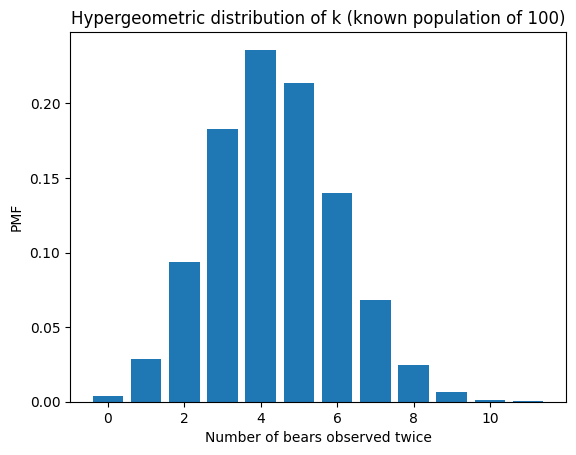

In [6]:
plt.bar(ks, ps)
plt.title('Hypergeometric distribution of k (known population of 100)')
plt.xlabel('Number of bears observed twice')
plt.ylabel('PMF')

In [7]:
# We've estimated k given N, K, and n.
# Now, given K, n, and k, how can we estimate N?

qs = np.arange(50, 501)
prior_N = make_uniform(qs, name='N')
prior_N.shape

(451,)

In [8]:
# We use hypergeom with constant K and n to compute the likelihood

Ns = prior_N.qs
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

posterior_N = prior_N * likelihood
posterior_N.normalize()

np.float64(0.07755224277106798)

<Axes: title={'center': 'Posterior distribution of N'}, xlabel='Population of bears (N)', ylabel='PDF'>

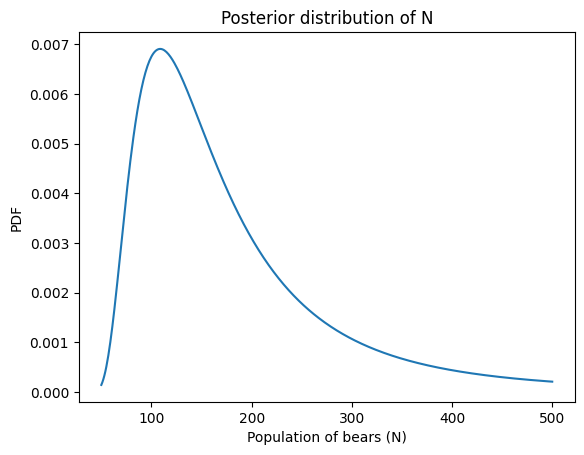

In [9]:
posterior_N.plot(title='Posterior distribution of N', xlabel='Population of bears (N)', ylabel='PDF')

In [10]:
posterior_N.max_prob()

np.int64(109)

In [11]:
posterior_N.mean()

np.float64(173.79880627085805)

In [12]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

In [13]:
# We can possibly improve on this wide interval by modeling the unknown probability of observing a bear

k10 = 23 - 4 # No bears observed in 1st round but not the 2nd
k01 = 19 - 4 # No bears observed in 2nd round but not the 1st
k11 = 4 # No bears observed in both rounds

# Say we know N=100 and p=0.2. Then we can use N to compute k00

N = 100

observed = k01 + k10 + k11
k00 = N - observed
k00

62

In [14]:
# For the update it's convenient to store the data as a list of categories

x = [k00, k01, k10, k11]
x

[62, 15, 19, 4]

In [15]:
# If we know p=0.2, we can compute the prob of a bear falling into each category

p=0.2
q = 1-p
y = [q*q, q*p, p*q, p*p]
y

[0.6400000000000001,
 0.16000000000000003,
 0.16000000000000003,
 0.04000000000000001]

In [16]:
# The probability of the data is given by the multinomial distribution

likelihood = multinomial.pmf(x, N, y)
likelihood

np.float64(0.0016664011988507257)

In [17]:
# Of course, we don't know N or p, so we need to choose priors for them

# We have prior_N

qs = np.linspace(0, 0.99, num=100)
prior_p = make_uniform(qs, name='p')

joint_prior = make_joint(prior_p, prior_N)
joint_prior.shape

(451, 100)

In [18]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head()

50  0.00    0.000022
    0.01    0.000022
    0.02    0.000022
dtype: float64

In [19]:
# Now we have to compute the likelihood for each pair of parameters

likelihood = joint_pmf.copy()

In [20]:
observed = k01 + k10 + k11

for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1 - p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = multinomial.pmf(x, N, y)

In [21]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

np.float64(2.9678796190279657e-05)

In [22]:
joint_posterior = posterior_pmf.unstack() # Converts the posterior back to a DataFrame

Text(0, 0.5, 'N')

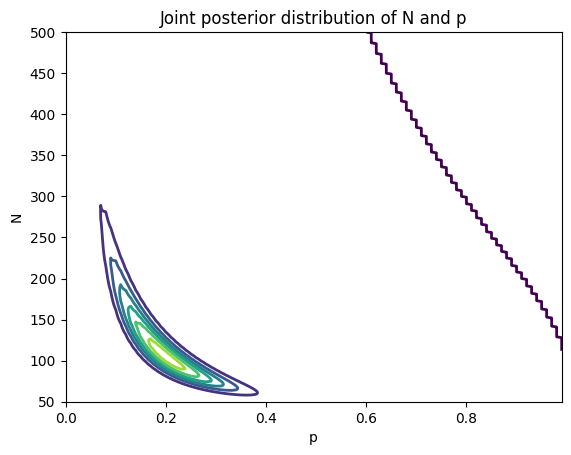

In [23]:
plot_contour(joint_posterior)
plt.title('Joint posterior distribution of N and p')
plt.xlabel('p')
plt.ylabel('N')

# Shape of the contour suggests that the parameters are correlated

In [24]:
posterior2_p = marginal(joint_posterior, 0)
posterior2_N = marginal(joint_posterior, 1)

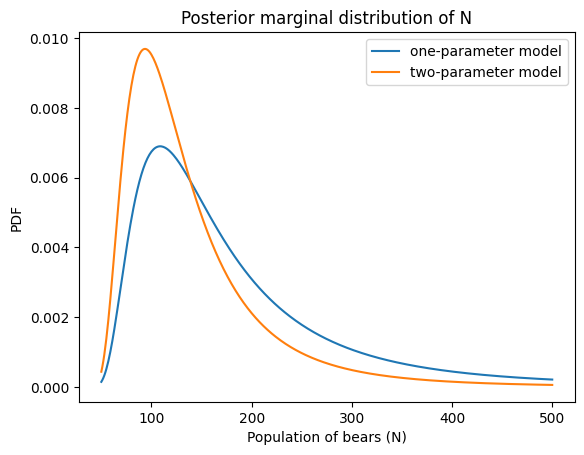

In [25]:
posterior_N.plot(label='one-parameter model', title='Posterior marginal distribution of N')
posterior2_N.plot(label='two-parameter model', xlabel='Population of bears (N)', ylabel='PDF')
plt.legend()

In [26]:
print(posterior_N.max_prob(), posterior2_N.max_prob())

109 94


In [27]:
print(posterior_N.mean(), posterior2_N.mean())

173.79880627085805 138.750521364726


In [28]:
print(posterior_N.credible_interval(0.9), posterior2_N.credible_interval(0.9))

[ 77. 363.] [ 68. 277.]


In [29]:
# Lincoln Index problem - using 2 testers to estimate the number of bugs in a computer program
# Suppose tester 1 finds 20 bugs, tester 2 finds 15, and they find 3 in common
# How can we use this information to estimate the number of bugs?

# Similar set up to the grizzly bear problem

k10 = 20 - 3
k01 = 15 - 3
k11 = 3

# It's probably not reasonable to assume that the testers have the same prob of finding a bug
# Assume the probabilities are independent
# Start by assuming that tester 1 finds 20% of bugs while tester 2 finds 15%

p0, p1 = 0.2, 0.15

# Compute the array of probabilities

def compute_probs(p0, p1):
    """Compute the probability for each of 4 categories"""
    q0 = 1-p0
    q1 = 1-p1
    return [q0*q1, q0*p1, p0*q1, p0*p1]

y = compute_probs(p0, p1)
y

[0.68, 0.12, 0.17, 0.03]

In [30]:
# If we pretend that these probs are known, we can compute the posterior for N
# This prior assumes a uniform with range 32-350

qs = np.arange(32, 350, step=5)
prior_N = make_uniform(qs, name='N')
prior_N.head(3)

,probs
N,
32,0.015625
37,0.015625
42,0.015625


In [31]:
# Put the data in an array, with 0 as a placeholder for the unknown k00

data = np.array([0, k01, k10, k11])

# Likelihoods for each value of N, with ps constant

likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, y)

In [32]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

np.float64(0.0003425201572557094)

<Axes: title={'center': 'Posterior marginal distribution of N with known p1, p2'}, xlabel='Number of bugs (N)', ylabel='PMF'>

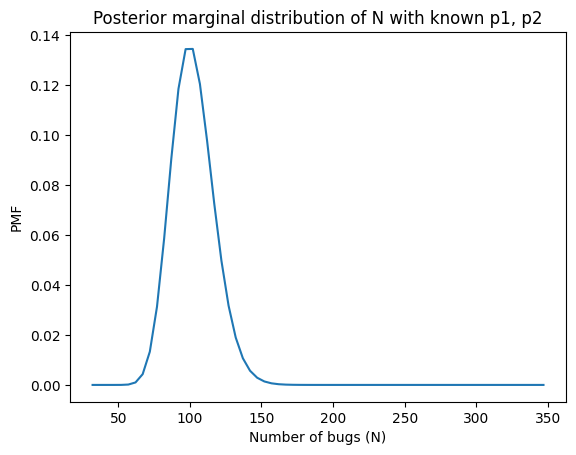

In [33]:
posterior_N.plot(title='Posterior marginal distribution of N with known p1, p2', xlabel='Number of bugs (N)', ylabel='PMF')

In [35]:
# But we don't know the probabilities, so we need a 3-parameter model.
# We'll use prior_N as before

qs = np.linspace(0, 1, num=51)
prior_p0 = make_uniform(qs, name='p0')
prior_p1 = make_uniform(qs, name='p1')

# These are then assembled into a joint prior with 3 dimensions

joint2 = make_joint(prior_p0, prior_N)
joint2.shape

(64, 51)

In [36]:
# Then we stack and put the results in a pmf

joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head(3)

32  0.00    0.000306
    0.02    0.000306
    0.04    0.000306
dtype: float64

In [38]:
# Use make_joint again to add the 3rd parameter

joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape # This is a DataFrame with N and p0 values in a multiindex down the rows and p1 as a column index

(3264, 51)

In [39]:
# Apply stack again

joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head(3)

(32, 0.0)  0.00    0.000006
           0.02    0.000006
           0.04    0.000006
dtype: float64

In [40]:
joint3_pmf.shape # This is large, so it'll take time to compute the likelihoods

(166464,)

In [42]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index: # It doesn't look like the stacking worked the way it's supposed to
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = multinomial.pmf(x, N, y)

ValueError: not enough values to unpack (expected 3, got 2)

In [43]:
# Exercise 15-1 - estimating number of people infected in a hepatitis outbreak

# 3 lists of cases:
# 1. 135 cases ID'd by serum test
# 2. 122 cases ID'd by local hospitals
# 3. 126 cases reported to epidemiologist questionnaires

# Make a joint prior and update using these data, then compute posterior mean for N and credible interval

# Additional data:
# - There are 73 cases on the 2nd list not on the 1st
# - There are 86 cases on the 1st list not on the 2nd
# - There are 49 cases on both lists

data2 = np.array([0, 73, 86, 49]) # These correspond to k00 (unknown), k01, k10, k11

# Assume each case has the same probability of appearing on each list
# So we use a 2-parameter model with N (total cases) and p (prob a case appears on any list)

# Prior for N

qs = np.arange(100, 1001, step=5)
prior_N = make_uniform(qs, name='N')

# Prior for p

qs = np.linspace(0, 0.98, num=50)
prior_p = make_uniform(qs, name='p')

joint_prior = make_joint(prior_p, prior_N)
joint_pmf = Pmf(joint_prior.stack())

likelihood = joint_pmf.copy()
x = data2.copy()
observed = data2.sum()

for N, p in joint_pmf.index:
    x[0] = N - observed
    q = 1 - p
    y = [q*q, q*p, p*q, p*p]
    likelihood.loc[N, p] = multinomial.pmf(x, N, y)
    
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

np.float64(4.198287756803538e-07)

In [44]:
joint_posterior = posterior_pmf.unstack()

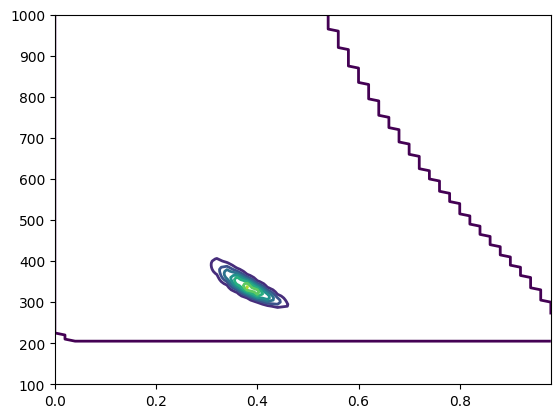

In [45]:
plot_contour(joint_posterior)

In [46]:
marginal_N = marginal(joint_posterior, 1)

<Axes: title={'center': 'Posterior marginal distribution of N'}, xlabel='Number of cases (N)', ylabel='PDF'>

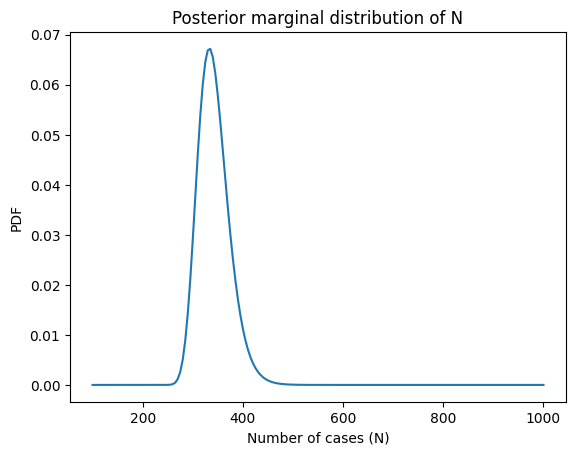

In [47]:
marginal_N.plot(title='Posterior marginal distribution of N', xlabel='Number of cases (N)', ylabel='PDF')

In [48]:
marginal_N.mean(), marginal_N.credible_interval(0.9) # I needed a little help, but my intuition was generally right

(np.float64(342.1666666666656), array([295., 400.]))

In [49]:
# Exercise 15-2 - Incorporate the data from the 3rd list

# Data provided in problem
# k000, k001, k010, k011, k100, k101, k110, k111

data3 = np.array([0, 63, 55, 18, 69, 17, 21, 28])

# To enumerate combinations of p and q probabilities, use Cartesian product

def cartesian_product(*args, **options):
    """Cartesian product of sequences.
    
    args: any number of sequences
    options: passes to `MultiIndex.from_product`
    
    returns: DataFrame with one column per sequence
    """
    index = pd.MultiIndex.from_product(args, **options)
    return pd.DataFrame(index=index).reset_index()

In [50]:
observed = data3.sum()
x = data3.copy()
likelihood = joint_pmf.copy()

for N, p in joint_pmf.index:
    x[0] = N - observed
    t = (1 - p, p)
    df = cartesian_product(t, t, t)
    y = df.prod(axis=1)
    likelihood.loc[N, p] = multinomial.pmf(x, N, y)
    
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

np.float64(8.7386647581495e-17)

In [51]:
joint_posterior = posterior_pmf.unstack()

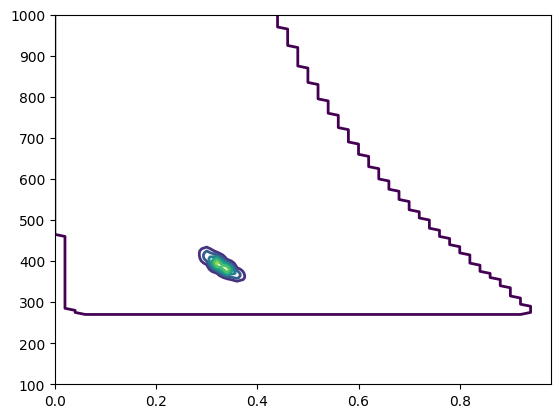

In [52]:
plot_contour(joint_posterior)

In [53]:
marginal3_N = marginal(joint_posterior, 1)

<Axes: title={'center': 'Posterior marginal distribution of N'}, xlabel='Number of cases (N)', ylabel='PDF'>

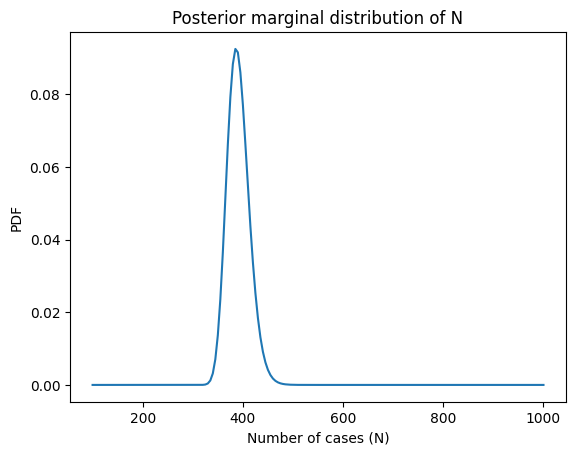

In [56]:
marginal3_N.plot(title='Posterior marginal distribution of N', xlabel='Number of cases (N)', ylabel='PDF')

In [57]:
marginal3_N.mean(), marginal3_N.credible_interval(0.9) # Needed help on the setup, but this is correct

(np.float64(391.01433052788065), array([360., 430.]))